<a href="https://colab.research.google.com/github/kaung-tcircuits/playground/blob/simclr_detect/tf2/colabs/finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# !mkdir /content/Firefighting_Device_Detection
!mkdir -p /content/Firefighting_Device_Detection/train
!mkdir -p /content/Firefighting_Device_Detection/test
!mkdir -p /content/Firefighting_Device_Detection/valid


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os

def analyze_split(df, split_name):
    """Analyze a single split of the dataset"""
    print(f"\n===== {split_name.upper()} Split Analysis =====")

    n_images = df['filename'].nunique()
    n_annotations = len(df)
    n_classes = df['class'].nunique()

    print(f"Total images: {n_images}")
    print(f"Total annotations: {n_annotations}")
    print(f"Total classes: {n_classes}")
    print(f"Average annotations per image: {n_annotations/n_images:.1f}")

    # Class distribution
    print("\nClass distribution (sorted by frequency):")
    class_dist = df['class'].value_counts()
    for class_name, count in class_dist.items():
        percentage = (count/n_annotations) * 100
        print(f"{class_name}: {count} ({percentage:.1f}%)")

    # Some size statistics
    print("\nBounding Box Statistics (pixels):")
    print(f"Average width: {df['box_width'].mean():.1f}")
    print(f"Average height: {df['box_height'].mean():.1f}")
    print(f"Average area: {df['box_area'].mean():.1f}")

    print("\nRelative Box Statistics (% of image):")
    print(f"Average width: {(df['relative_width'].mean()*100):.1f}%")
    print(f"Average height: {(df['relative_height'].mean()*100):.1f}%")
    print(f"Average area: {(df['relative_area'].mean()*100):.1f}%")

base_path = '/content/Firefighting_Device_Detection'
splits = ['train', 'test', 'valid']

columns = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']

dfs = {}
for split in splits:
    path = os.path.join(base_path, split, '_annotations.csv')
    df = pd.read_csv(path, names=columns, skiprows=1)
    for col in ['width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']:
        df[col] = pd.to_numeric(df[col], errors='raise')
    df['split'] = split

    df['box_width'] = df['xmax'] - df['xmin']
    df['box_height'] = df['ymax'] - df['ymin']
    df['box_area'] = df['box_width'] * df['box_height']
    df['box_aspect_ratio'] = df['box_width'] / df['box_height']
    df['relative_width'] = df['box_width'] / df['width']
    df['relative_height'] = df['box_height'] / df['height']
    df['relative_area'] = df['box_area'] / (df['width'] * df['height'])

    dfs[split] = df

    analyze_split(df, split)

# df_all = pd.concat(dfs.values(), ignore_index=True)



===== TRAIN Split Analysis =====
Total images: 102
Total annotations: 2606
Total classes: 40
Average annotations per image: 25.5

Class distribution (sorted by frequency):
24V-power-cord: 940 (36.1%)
fire-fan-manual-control-line: 341 (13.1%)
i-o-module: 151 (5.8%)
bus-isolation-module: 136 (5.2%)
coded-smoke-detector: 133 (5.1%)
fire-hydrant-button: 103 (4.0%)
acousto-optic-alarm: 93 (3.6%)
manual-alarm-button-with-fire-telephone-jack: 86 (3.3%)
manual-automatic-switching-device: 60 (2.3%)
coded-temperature-detector: 58 (2.2%)
input-module: 39 (1.5%)
normally-open-smoke-exhaust-valve-with-280-operation: 35 (1.3%)
fire-broadcasting-line: 34 (1.3%)
secondary-fire-shutter-door-control-box: 33 (1.3%)
dedicated-metal-module-box-for-fire-smoke-exhaust-fan: 31 (1.2%)
fire-water-pump-manual-control-line: 30 (1.2%)
light-display: 30 (1.2%)
security-video-intercom-door-machine: 25 (1.0%)
normally-open-smoke-exhaust-valve-with-70-operation: 25 (1.0%)
dedicated-metal-module-box-for-fire-supplemen

<a href="https://colab.research.google.com/github/google-research/simclr/blob/master/tf2/colabs/finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [7]:


import tensorflow.compat.v2 as tf
tf.compat.v1.enable_v2_behavior()
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib
import matplotlib.pyplot as plt

def inspect_simclr_model(base_model):
    sample_input = tf.zeros([1, 224, 224, 3])
    outputs = base_model(sample_input, trainable=False)

    print("=== SimCLR Output Analysis ===\n")

    print("\nSpatial Reduction Path:")
    spatial_features = []
    for name, tensor in outputs.items():
        if len(tensor.shape) == 4:
            spatial_features.append((name, - tensor.shape[1] * tensor.shape[2], tensor.shape[3], tensor.shape))
        if len(tensor.shape) == 2:
            spatial_features.append((name, float('inf'), - tensor.shape[1], tensor.shape))

    spatial_features.sort(key=lambda x: (x[1], x[2]))

    for name, resolution, channels, shape in spatial_features:
        print(f"{name:<15} shape: {shape} ")


base_model = hub.load("gs://simclr-checkpoints-tf2/simclrv2/pretrained/r50_1x_sk0/saved_model/")
inspect_simclr_model(base_model)

=== SimCLR Output Analysis ===


Spatial Reduction Path:
initial_conv    shape: (1, 112, 112, 64) 
initial_max_pool shape: (1, 56, 56, 64) 
block_group1    shape: (1, 56, 56, 256) 
block_group2    shape: (1, 28, 28, 512) 
block_group3    shape: (1, 14, 14, 1024) 
block_group4    shape: (1, 7, 7, 2048) 
final_avg_pool  shape: (1, 2048) 
logits_sup      shape: (1, 1000) 


In [27]:
class FirefightingDataset:
    def __init__(self, csv_path, img_dir, image_resize_pct=0.5):
        """Create a metadata object for image loading. Call create_dataset() for data pipeline."""
        # Read CSV
        self.df = pd.read_csv(csv_path, names=[
            'filename', 'width', 'height', 'class',
            'xmin', 'ymin', 'xmax', 'ymax'
        ], skiprows=1)

        self.img_dir = img_dir
        self.image_resize_pct = image_resize_pct
        self.image_ids = self.df['filename'].unique()

        self.classes = sorted(self.df['class'].unique())
        self.class_to_id = {cls: idx for idx, cls in enumerate(self.classes)}
        self.num_classes = len(self.classes)

    def load_image(self, image_id):
        """Load and preprocess image maintaining aspect ratio"""
        # Read image
        img_path = os.path.join(self.img_dir, image_id)
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image, channels=3)

        # Get original size
        orig_height = tf.cast(tf.shape(image)[0], tf.float32)
        orig_width = tf.cast(tf.shape(image)[1], tf.float32)

        # Calculate new size maintaining aspect ratio
        scale = self.image_resize_pct
        new_height = tf.cast(orig_height * scale, tf.int32)
        new_width = tf.cast(orig_width * scale, tf.int32)

        # Resize
        image = tf.image.resize(image, [new_height, new_width])

        # Normalize
        image = tf.cast(image, tf.float32) / 255.0

        return image, (orig_height, orig_width)

    def get_boxes(self, image_id, orig_size):
        """Get normalized boxes and classes for an image"""
        # Get annotations for this image
        annotations = self.df[self.df['filename'] == image_id]

        boxes = []
        classes = []

        orig_height, orig_width = orig_size

        for _, row in annotations.iterrows():
            # Normalize box coordinates
            xmin = row['xmin'] / orig_width
            ymin = row['ymin'] / orig_height
            xmax = row['xmax'] / orig_width
            ymax = row['ymax'] / orig_height

            boxes.append([xmin, ymin, xmax, ymax])
            classes.append(self.class_to_id[row['class']])

        return np.array(boxes, dtype=np.float32), np.array(classes, dtype=np.int32)

    def create_dataloader(self, batch_size=1):
        """Create tf.data.Dataset with dynamic shapes"""

        if batch_size > 1:
            raise ValueError("Batch size greater than 1 needs improved data preprocessing.")

        def generator():
            for image_id in self.image_ids:
                # Load image
                image, orig_size = self.load_image(image_id)

                # Get boxes and classes
                boxes, classes = self.get_boxes(image_id, orig_size)

                # Create targets dict
                targets = {
                    'boxes': boxes,
                    'classes': classes
                }

                yield image, targets

        # Create dataset with dynamic image dimensions
        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),
                {
                    'boxes': tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                    'classes': tf.TensorSpec(shape=(None,), dtype=tf.int32)
                }
            )
        )

        # Batch and prefetch
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

# Create datasets
train_dataset = FirefightingDataset(
    csv_path='/content/Firefighting_Device_Detection/train/_annotations.csv',
    img_dir='/content/Firefighting_Device_Detection/train',
)
train_loader = train_dataset.create_dataloader()

valid_loader = FirefightingDataset(
    csv_path='/content/Firefighting_Device_Detection/valid/_annotations.csv',
    img_dir='/content/Firefighting_Device_Detection/valid',
).create_dataloader()

In [29]:
class DetectionBackbone(tf.keras.Model):
    def __init__(self, simclr_model):
        super(DetectionBackbone, self).__init__()
        self.backbone = simclr_model

    def call(self, inputs):
        features = self.backbone(inputs, trainable=False)

        return {
            # 'C1': features['initial_conv'],
            # 'C2': features['initial_max_pool'],
            'P2': features['block_group1'],
            'P3': features['block_group2'],
            'P4': features['block_group3'],
            'P5': features['block_group4']
        }

# backbone = DetectionBackbone(base_model)

In [30]:
class FPN(tf.keras.layers.Layer):
    def __init__(self, out_channels=256):
        super(FPN, self).__init__()

        # 1x1 convo to reduce channels
        self.conv1_p5 = tf.keras.layers.Conv2D(out_channels, 1)
        self.conv1_p4 = tf.keras.layers.Conv2D(out_channels, 1)
        self.conv1_p3 = tf.keras.layers.Conv2D(out_channels, 1)
        self.conv1_p2 = tf.keras.layers.Conv2D(out_channels, 1)

        # 3x3 convo to smooth features
        self.smooth_p5 = tf.keras.layers.Conv2D(out_channels, 3, padding='same')
        self.smooth_p4 = tf.keras.layers.Conv2D(out_channels, 3, padding='same')
        self.smooth_p3 = tf.keras.layers.Conv2D(out_channels, 3, padding='same')
        self.smooth_p2 = tf.keras.layers.Conv2D(out_channels, 3, padding='same')

    def call(self, features):
        # Get features from SimCLR
        p5 = features['block_group4']
        p4 = features['block_group3']
        p3 = features['block_group2']
        p2 = features['block_group1']

        # Top-down pathway
        p5_out = self.conv1_p5(p5)

        p4_out = self.conv1_p4(p4)
        p4_out = p4_out + tf.image.resize(p5_out, tf.shape(p4_out)[1:3])

        p3_out = self.conv1_p3(p3)
        p3_out = p3_out + tf.image.resize(p4_out, tf.shape(p3_out)[1:3])

        p2_out = self.conv1_p2(p2)
        p2_out = p2_out + tf.image.resize(p3_out, tf.shape(p2_out)[1:3])

        # Final smooth
        return {
            'P5': self.smooth_p5(p5_out),
            'P4': self.smooth_p4(p4_out),
            'P3': self.smooth_p3(p3_out),
            'P2': self.smooth_p2(p2_out)
        }

In [21]:
class DetectionHead(tf.keras.layers.Layer):
    def __init__(self, num_classes):
        super(DetectionHead, self).__init__()

        # Classification branch
        self.cls_conv = tf.keras.Sequential([
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(num_classes, 3, padding='same')
        ])

        # Box regression branch
        self.box_conv = tf.keras.Sequential([
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(4, 3, padding='same')  # (x, y, w, h)
        ])

    def call(self, features):
        return {
            'cls_logits': self.cls_conv(features),
            'box_pred': self.box_conv(features)
        }

In [31]:
class DetectionModel(tf.keras.Model):
    def __init__(self, simclr_model, num_classes):
        super(DetectionModel, self).__init__()

        # SimCLR backbone
        self.backbone = simclr_model

        #FPN
        self.fpn = FPN()

        #Detection heads
        self.detection_heads = {
            'P2': DetectionHead(num_classes),
            'P3': DetectionHead(num_classes),
            'P4': DetectionHead(num_classes),
            'P5': DetectionHead(num_classes)
        }

    def call(self, inputs):
        # Backbone -> fpn -> detection heads
        features = self.backbone(inputs, trainable=False)
        fpn_features = self.fpn(features)
        predictions = {}
        for level in ['P2', 'P3', 'P4', 'P5']:
            predictions[level] = self.detection_heads[level](fpn_features[level])

        return predictions

In [32]:
class SimplifiedDetectionLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
        self.cls_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.box_loss_fn = tf.keras.losses.Huber()

    def call(self, y_true, y_pred):
        # Print shapes for debugging
        print("\nGround Truth shapes:")
        print(f"gt_boxes: {y_true['boxes'].shape}")
        print(f"gt_classes: {y_true['classes'].shape}")

        # Get ground truth
        gt_boxes = y_true['boxes']
        gt_classes = y_true['classes']

        total_loss = 0.0
        num_levels = len(['P2', 'P3', 'P4', 'P5'])

        for level in ['P2', 'P3', 'P4', 'P5']:
            level_preds = y_pred[level]

            # Get predictions
            pred_cls = level_preds['cls_logits']  # [1, H, W, 40]
            pred_box = level_preds['box_pred']    # [1, H, W, 4]

            print(f"\nLevel {level} shapes:")
            print(f"pred_cls: {pred_cls.shape}")
            print(f"pred_box: {pred_box.shape}")

            # Reshape predictions
            pred_cls = tf.reshape(pred_cls, [1, -1, 40])  # [1, H*W, 40]
            pred_box = tf.reshape(pred_box, [1, -1, 4])   # [1, H*W, 4]

            # Calculate IoU
            iou = self._compute_iou(
                tf.squeeze(pred_box, axis=0),
                tf.squeeze(gt_boxes, axis=0)
            )

            # Get best predictions for each ground truth
            best_idx = tf.argmax(iou, axis=0)  # [10]

            # Gather best predictions
            batch_idx = tf.zeros_like(best_idx)  # [10]
            gather_idx = tf.stack([batch_idx, best_idx], axis=1)  # [10, 2]

            matched_cls = tf.gather_nd(pred_cls, gather_idx)  # [10, 40]
            matched_box = tf.gather_nd(pred_box, gather_idx)  # [10, 4]

            # Calculate losses
            cls_loss = self.cls_loss_fn(
                tf.squeeze(gt_classes, axis=0),  # [10]
                matched_cls                      # [10, 40]
            )

            box_loss = self.box_loss_fn(
                tf.squeeze(gt_boxes, axis=0),    # [10, 4]
                matched_box                      # [10, 4]
            )

            # Add to total loss
            total_loss += (cls_loss + box_loss) / num_levels

        return total_loss

    def _compute_iou(self, boxes1, boxes2):
        """Compute IoU between two sets of boxes"""
        # boxes1: [H*W, 4], boxes2: [10, 4]

        # Calculate intersection coordinates
        x1 = tf.maximum(boxes1[:, None, 0], boxes2[None, :, 0])
        y1 = tf.maximum(boxes1[:, None, 1], boxes2[None, :, 1])
        x2 = tf.minimum(boxes1[:, None, 2], boxes2[None, :, 2])
        y2 = tf.minimum(boxes1[:, None, 3], boxes2[None, :, 3])

        # Calculate intersection area
        intersection = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)

        # Calculate box areas
        area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
        area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

        # Calculate union area
        union = area1[:, None] + area2[None, :] - intersection

        return intersection / (union + 1e-7)

In [24]:
class Trainer:
    def __init__(self, model, learning_rate=1e-4):
        self.model = model
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.loss_fn = SimplifiedDetectionLoss()

        # Metrics - use reset_state() instead of reset_states()
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')

    @tf.function
    def train_step(self, images, targets):
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = self.model(images, training=True)

            # Calculate loss
            loss = self.loss_fn(targets, predictions)

        # Calculate gradients
        gradients = tape.gradient(loss, self.model.trainable_variables)

        # Apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # Update metrics
        self.train_loss.update_state(loss)

        return loss

    def train(self, train_dataset, epochs=10):
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")

            # Reset metrics - use reset_state()
            self.train_loss.reset_state()

            # Progress bar
            progress_bar = tf.keras.utils.Progbar(
                len(list(train_dataset)),
                stateful_metrics=['loss']
            )

            # Training loop
            for step, (images, targets) in enumerate(train_dataset):
                loss = self.train_step(images, targets)

                # Update progress bar
                progress_bar.update(
                    step + 1,
                    values=[('loss', self.train_loss.result())]
                )

            # Print epoch results
            print(f"\nEpoch {epoch + 1} - Loss: {self.train_loss.result():.4f}")

In [26]:

# Now we can use it in our training
def train_detector():
    # Load SimCLR model
    base_model = hub.load("gs://simclr-checkpoints-tf2/simclrv2/pretrained/r50_1x_sk0/saved_model/")

    # Create detector
    detector = DetectionModel(
        simclr_model=base_model,
        num_classes=train_dataset.num_classes
    )

    # Create trainer
    trainer = Trainer(detector)

    # Train
    trainer.train(train_loader, epochs=10)

    return detector

# Start training
model = train_detector()


Epoch 1/10


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot batch tensors with different shapes in component 0. First element had shape [341,413,3] and element 4 had shape [348,399,3]. [Op:IteratorGetNext] name: 

In [49]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches  # Add this import
import numpy as np

class DetectionEvaluator:
    def __init__(self, model, test_dataset, class_names):
        self.model = model
        self.test_dataset = test_dataset
        self.class_names = class_names

    def predict_single_image(self, image, confidence_threshold=0.5, iou_threshold=0.9):
        """Make prediction on a single image with NMS"""
        # Add batch dimension if needed
        if len(image.shape) == 3:
            image = tf.expand_dims(image, 0)

        # Get predictions
        predictions = self.model(image, training=False)

        # Process predictions from all FPN levels
        all_boxes = []
        all_scores = []
        all_classes = []

        for level in ['P2', 'P3', 'P4', 'P5']:
            level_preds = predictions[level]

            # Get boxes and class predictions
            boxes = level_preds['box_pred'][0]  # Remove batch dim
            class_logits = level_preds['cls_logits'][0]  # Remove batch dim

            # Convert logits to probabilities
            class_probs = tf.nn.softmax(class_logits, axis=-1)

            # Get highest probability and corresponding class
            scores = tf.reduce_max(class_probs, axis=-1)
            classes = tf.argmax(class_probs, axis=-1)

            # Filter by confidence threshold
            mask = scores > confidence_threshold
            boxes = boxes[mask]
            scores = scores[mask]
            classes = classes[mask]

            all_boxes.append(boxes)
            all_scores.append(scores)
            all_classes.append(classes)

        # Combine predictions from all levels
        boxes = tf.concat(all_boxes, axis=0)
        scores = tf.concat(all_scores, axis=0)
        classes = tf.concat(all_classes, axis=0)

        # Apply NMS
        selected_indices = tf.image.non_max_suppression(
            boxes=boxes,
            scores=scores,
            max_output_size=100,  # Maximum number of boxes to keep
            iou_threshold=iou_threshold
        )

        boxes = tf.gather(boxes, selected_indices)
        scores = tf.gather(scores, selected_indices)
        classes = tf.gather(classes, selected_indices)

        return boxes, scores, classes

    def visualize_prediction(self, image, boxes, scores, classes, ground_truth=None):
        """Visualize predictions and ground truth on image"""
        # Convert to numpy for visualization
        image_np = image.numpy()
        boxes_np = boxes.numpy()
        scores_np = scores.numpy()
        classes_np = classes.numpy()

        # Create figure and axes
        fig, ax = plt.subplots(1, figsize=(12, 12))
        ax.imshow(image_np)

        # Draw predicted boxes in red
        for box, score, class_id in zip(boxes_np, scores_np, classes_np):
            xmin, ymin, xmax, ymax = box

            # Convert normalized coordinates to pixel coordinates
            height, width = image_np.shape[:2]
            xmin = xmin * width
            xmax = xmax * width
            ymin = ymin * height
            ymax = ymax * height

            # Create rectangle
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)

            # Add label
            class_name = self.class_names[class_id]
            label = f'{class_name}: {score:.2f}'
            ax.text(
                xmin, ymin - 5,
                label,
                color='r',
                fontsize=12,
                backgroundcolor='white'
            )

        # Draw ground truth boxes in green if provided
        if ground_truth is not None:
            gt_boxes = ground_truth['boxes'][0].numpy()
            gt_classes = ground_truth['classes'][0].numpy()

            for box, class_id in zip(gt_boxes, gt_classes):
                xmin, ymin, xmax, ymax = box

                # Convert normalized coordinates to pixel coordinates
                height, width = image_np.shape[:2]
                xmin = xmin * width
                xmax = xmax * width
                ymin = ymin * height
                ymax = ymax * height

                # Create rectangle
                rect = patches.Rectangle(
                    (xmin, ymin),
                    xmax - xmin,
                    ymax - ymin,
                    linewidth=2,
                    edgecolor='g',
                    facecolor='none'
                )
                ax.add_patch(rect)

                # Add label
                class_name = self.class_names[class_id]
                ax.text(
                    xmin, ymin - 20,
                    f'GT: {class_name}',
                    color='g',
                    fontsize=12,
                    backgroundcolor='white'
                )

        plt.axis('off')
        plt.show()

    def evaluate_dataset(self, num_images=5, confidence_threshold=0.5):
        """Evaluate a subset of test dataset"""
        for i, (image, targets) in enumerate(self.test_dataset):
            if i >= num_images:
                break

            # Get predictions
            boxes, scores, classes = self.predict_single_image(
                image[0],  # Take first image from batch
                confidence_threshold
            )

            # Visualize results with ground truth
            self.visualize_prediction(image[0], boxes, scores, classes, targets)
            print(f"Comparing truth vs predicted numbers: {len(targets['boxes'][0])} vs {len(boxes)}")
            # print(f"\nImage {i+1}:")
            # print("\nGround Truth:")
            # for box, cls in zip(targets['boxes'][0], targets['classes'][0]):
            #     print(f"Class: {self.class_names[cls.numpy()]}, Box: {box.numpy()}")

            # print("\nPredictions:")
            # for box, score, cls in zip(boxes.numpy(), scores.numpy(), classes.numpy()):
            #     print(f"Class: {self.class_names[cls]}, Score: {score:.2f}, Box: {box}")

            print("\n" + "="*50 + "\n")

# Create test dataset
test_dataset = FirefightingDataset(
    csv_path='/content/Firefighting_Device_Detection/test/_annotations.csv',
    img_dir='/content/Firefighting_Device_Detection/test',
    image_size=224
).create_dataset(batch_size=1)

# Create evaluator and evaluate
evaluator = DetectionEvaluator(
    model=model,  # Use the model we just trained
    test_dataset=test_dataset,
    class_names=train_dataset.classes
)

# Evaluate first 5 images
evaluator.evaluate_dataset(num_images=5, confidence_threshold=0.95)


Comparing truth vs predicted numbers: 12 vs 86


Comparing truth vs predicted numbers: 17 vs 41


Comparing truth vs predicted numbers: 8 vs 88


Comparing truth vs predicted numbers: 10 vs 98


Comparing truth vs predicted numbers: 44 vs 100




In [35]:
class DetectionEvaluator:
    def __init__(self, model, test_dataset, class_names):
        self.model = model
        self.test_dataset = test_dataset
        self.class_names = class_names

    def predict_single_image(self, image, confidence_threshold=0.5):
        """Make prediction on a single image"""
        # Add batch dimension
        image_batch = tf.expand_dims(image, 0)

        # Get predictions
        predictions = self.model(image_batch, training=False)

        # Process predictions from all FPN levels
        all_boxes = []
        all_scores = []
        all_classes = []

        for level in ['P2', 'P3', 'P4', 'P5']:
            level_preds = predictions[level]

            # Get boxes and class predictions
            boxes = level_preds['box_pred'][0]  # Remove batch dim
            class_logits = level_preds['cls_logits'][0]  # Remove batch dim

            # Convert logits to probabilities
            class_probs = tf.nn.softmax(class_logits, axis=-1)

            # Get highest probability and corresponding class
            scores = tf.reduce_max(class_probs, axis=-1)
            classes = tf.argmax(class_probs, axis=-1)

            # Filter by confidence threshold
            mask = scores > confidence_threshold
            boxes = boxes[mask]
            scores = scores[mask]
            classes = classes[mask]

            all_boxes.append(boxes)
            all_scores.append(scores)
            all_classes.append(classes)

        # Combine predictions from all levels
        boxes = tf.concat(all_boxes, axis=0)
        scores = tf.concat(all_scores, axis=0)
        classes = tf.concat(all_classes, axis=0)

        return boxes, scores, classes

    def visualize_prediction(self, image, boxes, scores, classes):
        """Visualize predictions on image"""
        # Convert to numpy for visualization
        image_np = image.numpy()
        boxes_np = boxes.numpy()
        scores_np = scores.numpy()
        classes_np = classes.numpy()

        # Create figure and axes
        fig, ax = plt.subplots(1, figsize=(12, 12))
        ax.imshow(image_np)

        # Draw each box
        for box, score, class_id in zip(boxes_np, scores_np, classes_np):
            xmin, ymin, xmax, ymax = box

            # Convert normalized coordinates to pixel coordinates
            height, width = image_np.shape[:2]
            xmin = xmin * width
            xmax = xmax * width
            ymin = ymin * height
            ymax = ymax * height

            # Create rectangle
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)

            # Add label
            class_name = self.class_names[class_id]
            label = f'{class_name}: {score:.2f}'
            ax.text(
                xmin, ymin - 5,
                label,
                color='r',
                fontsize=12,
                backgroundcolor='white'
            )

        plt.axis('off')
        plt.show()

    def evaluate_dataset(self, confidence_threshold=0.5):
        """Evaluate entire test dataset"""
        for image, targets in self.test_dataset:
            # Get predictions
            boxes, scores, classes = self.predict_single_image(
                image[0],  # Take first image from batch
                confidence_threshold
            )

            # Visualize results
            self.visualize_prediction(image[0], boxes, scores, classes)

            # Print ground truth vs predictions
            print("Ground Truth:")
            for box, cls in zip(targets['boxes'][0], targets['classes'][0]):
                print(f"Class: {self.class_names[cls.numpy()]}, Box: {box.numpy()}")

            print("\nPredictions:")
            for box, score, cls in zip(boxes.numpy(), scores.numpy(), classes.numpy()):
                print(f"Class: {self.class_names[cls]}, Score: {score:.2f}, Box: {box}")

            print("\n" + "="*50 + "\n")

            # Optional: wait for user input to continue
            input("Press Enter to continue...")

# Create test dataset
test_dataset = FirefightingDataset(
    csv_path='/content/Firefighting_Device_Detection/test/_annotations.csv',
    img_dir='/content/Firefighting_Device_Detection/test',
    image_size=224
).create_dataset(batch_size=1)  # Batch size 1 for easier visualization

# Load best model weights
model.load_weights('best_model.h5')

# Create evaluator
evaluator = DetectionEvaluator(
    model=model,
    test_dataset=test_dataset,
    class_names=train_dataset.classes  # Class names from training dataset
)

# Run evaluation
evaluator.evaluate_dataset(confidence_threshold=0.5)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## SimCLR: A Simple Framework for Contrastive Learning of Visual Representations

This colab demonstrates how to load pretrained/finetuned SimCLR models from hub modules for fine-tuning

The checkpoints are accessible in the following Google Cloud Storage folders.

* Pretrained SimCLRv2 models with a linear classifier: [gs://simclr-checkpoints-tf2/simclrv2/pretrained](https://console.cloud.google.com/storage/browser/simclr-checkpoints-tf2/simclrv2/pretrained)
* Fine-tuned SimCLRv2 models on 1% of labels: [gs://simclr-checkpoints-tf2/simclrv2/finetuned_1pct](https://console.cloud.google.com/storage/browser/simclr-checkpoints-tf2/simclrv2/finetuned_1pct)
* Fine-tuned SimCLRv2 models on 10% of labels: [gs://simclr-checkpoints-tf2/simclrv2/finetuned_10pct](https://console.cloud.google.com/storage/browser/simclr-checkpoints-tf2/simclrv2/finetuned_10pct)
* Fine-tuned SimCLRv2 models on 100% of labels: [gs://simclr-checkpoints-tf2/simclrv2/finetuned_100pct](https://console.cloud.google.com/storage/browser/simclr-checkpoints-tf2/simclrv2/finetuned_100pct)
* Supervised models with the same architectures: [gs://simclr-checkpoints-tf2/simclrv2/pretrained](https://console.cloud.google.com/storage/browser/simclr-checkpoints-tf2/simclrv2/pretrained)

Use the corresponding checkpoint / hub-module paths for accessing the model. For example, to use a pre-trained model (with a linear classifier) with ResNet-152 (2x+SK), set the path to `gs://simclr-checkpoints-tf2/simclrv2/pretrained/r152_2x_sk1`.

In [29]:
import re
import numpy as np

import tensorflow.compat.v2 as tf
tf.compat.v1.enable_v2_behavior()
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib
import matplotlib.pyplot as plt

In [ ]:
#@title Load class id to label text mapping from big_transfer (hidden)
# Code snippet credit: https://github.com/google-research/big_transfer

!wget --no-check-certificate https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt

imagenet_int_to_str = {}

with open('ilsvrc2012_wordnet_lemmas.txt', 'r') as f:
  for i in range(1000):
    row = f.readline()
    row = row.rstrip()
    imagenet_int_to_str.update({i: row})

tf_flowers_labels = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

--2025-02-07 07:51:57--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.207, 74.125.69.207, 64.233.181.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt.25’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2025-02-07 07:51:58 (134 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt.25’ saved [21675/21675]



In [ ]:
#@title Preprocessing functions from data_util.py in SimCLR repository (hidden).

FLAGS_color_jitter_strength = 0.3
CROP_PROPORTION = 0.875  # Standard for ImageNet.


def random_apply(func, p, x):
  """Randomly apply function func to x with probability p."""
  return tf.cond(
      tf.less(tf.random_uniform([], minval=0, maxval=1, dtype=tf.float32),
              tf.cast(p, tf.float32)),
      lambda: func(x),
      lambda: x)


def random_brightness(image, max_delta, impl='simclrv2'):
  """A multiplicative vs additive change of brightness."""
  if impl == 'simclrv2':
    factor = tf.random_uniform(
        [], tf.maximum(1.0 - max_delta, 0), 1.0 + max_delta)
    image = image * factor
  elif impl == 'simclrv1':
    image = random_brightness(image, max_delta=max_delta)
  else:
    raise ValueError('Unknown impl {} for random brightness.'.format(impl))
  return image


def to_grayscale(image, keep_channels=True):
  image = tf.image.rgb_to_grayscale(image)
  if keep_channels:
    image = tf.tile(image, [1, 1, 3])
  return image


def color_jitter(image,
                 strength,
                 random_order=True):
  """Distorts the color of the image.
  Args:
    image: The input image tensor.
    strength: the floating number for the strength of the color augmentation.
    random_order: A bool, specifying whether to randomize the jittering order.
  Returns:
    The distorted image tensor.
  """
  brightness = 0.8 * strength
  contrast = 0.8 * strength
  saturation = 0.8 * strength
  hue = 0.2 * strength
  if random_order:
    return color_jitter_rand(image, brightness, contrast, saturation, hue)
  else:
    return color_jitter_nonrand(image, brightness, contrast, saturation, hue)


def color_jitter_nonrand(image, brightness=0, contrast=0, saturation=0, hue=0):
  """Distorts the color of the image (jittering order is fixed).
  Args:
    image: The input image tensor.
    brightness: A float, specifying the brightness for color jitter.
    contrast: A float, specifying the contrast for color jitter.
    saturation: A float, specifying the saturation for color jitter.
    hue: A float, specifying the hue for color jitter.
  Returns:
    The distorted image tensor.
  """
  with tf.name_scope('distort_color'):
    def apply_transform(i, x, brightness, contrast, saturation, hue):
      """Apply the i-th transformation."""
      if brightness != 0 and i == 0:
        x = random_brightness(x, max_delta=brightness)
      elif contrast != 0 and i == 1:
        x = tf.image.random_contrast(
            x, lower=1-contrast, upper=1+contrast)
      elif saturation != 0 and i == 2:
        x = tf.image.random_saturation(
            x, lower=1-saturation, upper=1+saturation)
      elif hue != 0:
        x = tf.image.random_hue(x, max_delta=hue)
      return x

    for i in range(4):
      image = apply_transform(i, image, brightness, contrast, saturation, hue)
      image = tf.clip_by_value(image, 0., 1.)
    return image


def color_jitter_rand(image, brightness=0, contrast=0, saturation=0, hue=0):
  """Distorts the color of the image (jittering order is random).
  Args:
    image: The input image tensor.
    brightness: A float, specifying the brightness for color jitter.
    contrast: A float, specifying the contrast for color jitter.
    saturation: A float, specifying the saturation for color jitter.
    hue: A float, specifying the hue for color jitter.
  Returns:
    The distorted image tensor.
  """
  with tf.name_scope('distort_color'):
    def apply_transform(i, x):
      """Apply the i-th transformation."""
      def brightness_foo():
        if brightness == 0:
          return x
        else:
          return random_brightness(x, max_delta=brightness)
      def contrast_foo():
        if contrast == 0:
          return x
        else:
          return tf.image.random_contrast(x, lower=1-contrast, upper=1+contrast)
      def saturation_foo():
        if saturation == 0:
          return x
        else:
          return tf.image.random_saturation(
              x, lower=1-saturation, upper=1+saturation)
      def hue_foo():
        if hue == 0:
          return x
        else:
          return tf.image.random_hue(x, max_delta=hue)
      x = tf.cond(tf.less(i, 2),
                  lambda: tf.cond(tf.less(i, 1), brightness_foo, contrast_foo),
                  lambda: tf.cond(tf.less(i, 3), saturation_foo, hue_foo))
      return x

    perm = tf.random_shuffle(tf.range(4))
    for i in range(4):
      image = apply_transform(perm[i], image)
      image = tf.clip_by_value(image, 0., 1.)
    return image


def _compute_crop_shape(
    image_height, image_width, aspect_ratio, crop_proportion):
  """Compute aspect ratio-preserving shape for central crop.
  The resulting shape retains `crop_proportion` along one side and a proportion
  less than or equal to `crop_proportion` along the other side.
  Args:
    image_height: Height of image to be cropped.
    image_width: Width of image to be cropped.
    aspect_ratio: Desired aspect ratio (width / height) of output.
    crop_proportion: Proportion of image to retain along the less-cropped side.
  Returns:
    crop_height: Height of image after cropping.
    crop_width: Width of image after cropping.
  """
  image_width_float = tf.cast(image_width, tf.float32)
  image_height_float = tf.cast(image_height, tf.float32)

  def _requested_aspect_ratio_wider_than_image():
    crop_height = tf.cast(tf.math.rint(
        crop_proportion / aspect_ratio * image_width_float), tf.int32)
    crop_width = tf.cast(tf.math.rint(
        crop_proportion * image_width_float), tf.int32)
    return crop_height, crop_width

  def _image_wider_than_requested_aspect_ratio():
    crop_height = tf.cast(
        tf.math.rint(crop_proportion * image_height_float), tf.int32)
    crop_width = tf.cast(tf.math.rint(
        crop_proportion * aspect_ratio *
        image_height_float), tf.int32)
    return crop_height, crop_width

  return tf.cond(
      aspect_ratio > image_width_float / image_height_float,
      _requested_aspect_ratio_wider_than_image,
      _image_wider_than_requested_aspect_ratio)


def center_crop(image, height, width, crop_proportion):
  """Crops to center of image and rescales to desired size.
  Args:
    image: Image Tensor to crop.
    height: Height of image to be cropped.
    width: Width of image to be cropped.
    crop_proportion: Proportion of image to retain along the less-cropped side.
  Returns:
    A `height` x `width` x channels Tensor holding a central crop of `image`.
  """
  shape = tf.shape(image)
  image_height = shape[0]
  image_width = shape[1]
  crop_height, crop_width = _compute_crop_shape(
      image_height, image_width, height / width, crop_proportion)
  offset_height = ((image_height - crop_height) + 1) // 2
  offset_width = ((image_width - crop_width) + 1) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_height, offset_width, crop_height, crop_width)

  image = tf.compat.v1.image.resize_bicubic([image], [height, width])[0]

  return image


def distorted_bounding_box_crop(image,
                                bbox,
                                min_object_covered=0.1,
                                aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0),
                                max_attempts=100,
                                scope=None):
  """Generates cropped_image using one of the bboxes randomly distorted.
  See `tf.image.sample_distorted_bounding_box` for more documentation.
  Args:
    image: `Tensor` of image data.
    bbox: `Tensor` of bounding boxes arranged `[1, num_boxes, coords]`
        where each coordinate is [0, 1) and the coordinates are arranged
        as `[ymin, xmin, ymax, xmax]`. If num_boxes is 0 then use the whole
        image.
    min_object_covered: An optional `float`. Defaults to `0.1`. The cropped
        area of the image must contain at least this fraction of any bounding
        box supplied.
    aspect_ratio_range: An optional list of `float`s. The cropped area of the
        image must have an aspect ratio = width / height within this range.
    area_range: An optional list of `float`s. The cropped area of the image
        must contain a fraction of the supplied image within in this range.
    max_attempts: An optional `int`. Number of attempts at generating a cropped
        region of the image of the specified constraints. After `max_attempts`
        failures, return the entire image.
    scope: Optional `str` for name scope.
  Returns:
    (cropped image `Tensor`, distorted bbox `Tensor`).
  """
  with tf.name_scope(scope, 'distorted_bounding_box_crop', [image, bbox]):
    shape = tf.shape(image)
    sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes=bbox,
        min_object_covered=min_object_covered,
        aspect_ratio_range=aspect_ratio_range,
        area_range=area_range,
        max_attempts=max_attempts,
        use_image_if_no_bounding_boxes=True)
    bbox_begin, bbox_size, _ = sample_distorted_bounding_box

    # Crop the image to the specified bounding box.
    offset_y, offset_x, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, target_height, target_width)

    return image


def crop_and_resize(image, height, width):
  """Make a random crop and resize it to height `height` and width `width`.
  Args:
    image: Tensor representing the image.
    height: Desired image height.
    width: Desired image width.
  Returns:
    A `height` x `width` x channels Tensor holding a random crop of `image`.
  """
  bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
  aspect_ratio = width / height
  image = distorted_bounding_box_crop(
      image,
      bbox,
      min_object_covered=0.1,
      aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
      area_range=(0.08, 1.0),
      max_attempts=100,
      scope=None)
  return tf.compat.v1.image.resize_bicubic([image], [height, width])[0]


def gaussian_blur(image, kernel_size, sigma, padding='SAME'):
  """Blurs the given image with separable convolution.
  Args:
    image: Tensor of shape [height, width, channels] and dtype float to blur.
    kernel_size: Integer Tensor for the size of the blur kernel. This is should
      be an odd number. If it is an even number, the actual kernel size will be
      size + 1.
    sigma: Sigma value for gaussian operator.
    padding: Padding to use for the convolution. Typically 'SAME' or 'VALID'.
  Returns:
    A Tensor representing the blurred image.
  """
  radius = tf.to_int32(kernel_size / 2)
  kernel_size = radius * 2 + 1
  x = tf.to_float(tf.range(-radius, radius + 1))
  blur_filter = tf.exp(
      -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.to_float(sigma), 2.0)))
  blur_filter /= tf.reduce_sum(blur_filter)
  # One vertical and one horizontal filter.
  blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
  blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
  num_channels = tf.shape(image)[-1]
  blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
  blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
  expand_batch_dim = image.shape.ndims == 3
  if expand_batch_dim:
    # Tensorflow requires batched input to convolutions, which we can fake with
    # an extra dimension.
    image = tf.expand_dims(image, axis=0)
  blurred = tf.nn.depthwise_conv2d(
      image, blur_h, strides=[1, 1, 1, 1], padding=padding)
  blurred = tf.nn.depthwise_conv2d(
      blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
  if expand_batch_dim:
    blurred = tf.squeeze(blurred, axis=0)
  return blurred


def random_crop_with_resize(image, height, width, p=1.0):
  """Randomly crop and resize an image.
  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    p: Probability of applying this transformation.
  Returns:
    A preprocessed image `Tensor`.
  """
  def _transform(image):  # pylint: disable=missing-docstring
    image = crop_and_resize(image, height, width)
    return image
  return random_apply(_transform, p=p, x=image)


def random_color_jitter(image, p=1.0):
  def _transform(image):
    color_jitter_t = functools.partial(
        color_jitter, strength=FLAGS_color_jitter_strength)
    image = random_apply(color_jitter_t, p=0.8, x=image)
    return random_apply(to_grayscale, p=0.2, x=image)
  return random_apply(_transform, p=p, x=image)


def random_blur(image, height, width, p=1.0):
  """Randomly blur an image.
  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    p: probability of applying this transformation.
  Returns:
    A preprocessed image `Tensor`.
  """
  del width
  def _transform(image):
    sigma = tf.random.uniform([], 0.1, 2.0, dtype=tf.float32)
    return gaussian_blur(
        image, kernel_size=height//10, sigma=sigma, padding='SAME')
  return random_apply(_transform, p=p, x=image)


def batch_random_blur(images_list, height, width, blur_probability=0.5):
  """Apply efficient batch data transformations.
  Args:
    images_list: a list of image tensors.
    height: the height of image.
    width: the width of image.
    blur_probability: the probaility to apply the blur operator.
  Returns:
    Preprocessed feature list.
  """
  def generate_selector(p, bsz):
    shape = [bsz, 1, 1, 1]
    selector = tf.cast(
        tf.less(tf.random_uniform(shape, 0, 1, dtype=tf.float32), p),
        tf.float32)
    return selector

  new_images_list = []
  for images in images_list:
    images_new = random_blur(images, height, width, p=1.)
    selector = generate_selector(blur_probability, tf.shape(images)[0])
    images = images_new * selector + images * (1 - selector)
    images = tf.clip_by_value(images, 0., 1.)
    new_images_list.append(images)

  return new_images_list


def preprocess_for_train(image, height, width,
                         color_distort=True, crop=True, flip=True):
  """Preprocesses the given image for training.
  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    color_distort: Whether to apply the color distortion.
    crop: Whether to crop the image.
    flip: Whether or not to flip left and right of an image.
  Returns:
    A preprocessed image `Tensor`.
  """
  if crop:
    image = random_crop_with_resize(image, height, width)
  if flip:
    image = tf.image.random_flip_left_right(image)
  if color_distort:
    image = random_color_jitter(image)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image


def preprocess_for_eval(image, height, width, crop=True):
  """Preprocesses the given image for evaluation.
  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    crop: Whether or not to (center) crop the test images.
  Returns:
    A preprocessed image `Tensor`.
  """
  if crop:
    image = center_crop(image, height, width, crop_proportion=CROP_PROPORTION)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image


def preprocess_image(image, height, width, is_training=False,
                     color_distort=True, test_crop=True):
  """Preprocesses the given image.
  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    is_training: `bool` for whether the preprocessing is for training.
    color_distort: whether to apply the color distortion.
    test_crop: whether or not to extract a central crop of the images
        (as for standard ImageNet evaluation) during the evaluation.
  Returns:
    A preprocessed image `Tensor` of range [0, 1].
  """
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  if is_training:
    return preprocess_for_train(image, height, width, color_distort)
  else:
    return preprocess_for_eval(image, height, width, test_crop)

In [ ]:
EETA_DEFAULT = 0.001


class LARSOptimizer(tf.keras.optimizers.Optimizer):
  """Layer-wise Adaptive Rate Scaling for large batch training.

  Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
  I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
  """

  def __init__(self,
               learning_rate,
               momentum=0.9,
               use_nesterov=False,
               weight_decay=0.0,
               exclude_from_weight_decay=None,
               exclude_from_layer_adaptation=None,
               classic_momentum=True,
               eeta=EETA_DEFAULT,
               name="LARSOptimizer"):
    """Constructs a LARSOptimizer.

    Args:
      learning_rate: A `float` for learning rate.
      momentum: A `float` for momentum.
      use_nesterov: A 'Boolean' for whether to use nesterov momentum.
      weight_decay: A `float` for weight decay.
      exclude_from_weight_decay: A list of `string` for variable screening, if
          any of the string appears in a variable's name, the variable will be
          excluded for computing weight decay. For example, one could specify
          the list like ['batch_normalization', 'bias'] to exclude BN and bias
          from weight decay.
      exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
          for layer adaptation. If it is None, it will be defaulted the same as
          exclude_from_weight_decay.
      classic_momentum: A `boolean` for whether to use classic (or popular)
          momentum. The learning rate is applied during momeuntum update in
          classic momentum, but after momentum for popular momentum.
      eeta: A `float` for scaling of learning rate when computing trust ratio.
      name: The name for the scope.
    """
    super(LARSOptimizer, self).__init__(name=name)

    #self._set_hyper("learning_rate", learning_rate)
    self._learning_rate = learning_rate
    self.momentum = momentum
    self.weight_decay = weight_decay
    self.use_nesterov = use_nesterov
    self.classic_momentum = classic_momentum
    self.eeta = eeta
    self.exclude_from_weight_decay = exclude_from_weight_decay
    self._momentums = {}
    # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
    # arg is None.
    if exclude_from_layer_adaptation:
      self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
    else:
      self.exclude_from_layer_adaptation = exclude_from_weight_decay

  # def _create_slots(self, var_list):
  #   for v in var_list:
  #     self.add_slot(v, "Momentum")


  def build(self, var_list):
      """Create optimizer variables."""
      super().build(var_list)
      if hasattr(self, "_built") and self._built:
          return
      # Initialize momentum variables for all trainable variables
      for var in var_list:
          momentum = self.add_variable_from_reference(
              model_variable=var,
              variable_name="momentum",
              initial_value=tf.zeros_like(var)
          )
          self._momentums[var.ref()] = momentum
      self._built = True

  def update_step(self, gradient, variable):
      """Implements LARS optimizer update step."""
      if gradient is None:
          return

      # Get momentum variable using the variable reference
      momentum = self._momentums[variable.ref()]

      # Get learning rate
      lr_t = tf.cast(self._learning_rate, variable.dtype)
      grad = tf.cast(gradient, variable.dtype)

      # Rest of the LARS implementation remains the same...

      # Apply weight decay if needed
      if self._use_weight_decay(variable.name):
          grad += self.weight_decay * variable

      # Compute trust ratio and scaled learning rate
      if self.classic_momentum:
          trust_ratio = 1.0
          if self._do_layer_adaptation(variable.name):
              w_norm = tf.norm(variable, ord=2)
              g_norm = tf.norm(grad, ord=2)
              trust_ratio = tf.where(
                  tf.greater(w_norm, 0),
                  tf.where(tf.greater(g_norm, 0),
                          (self.eeta * w_norm / g_norm), 1.0),
                  1.0)
          scaled_lr = lr_t * trust_ratio

          # Compute momentum and update
          next_v = tf.multiply(self.momentum, momentum) + scaled_lr * grad
          if self.use_nesterov:
              update = tf.multiply(self.momentum, next_v) + scaled_lr * grad
          else:
              update = next_v
      else:
          next_v = tf.multiply(self.momentum, momentum) + grad
          if self.use_nesterov:
              update = tf.multiply(self.momentum, next_v) + grad
          else:
              update = next_v

          trust_ratio = 1.0
          if self._do_layer_adaptation(variable.name):
              w_norm = tf.norm(variable, ord=2)
              v_norm = tf.norm(update, ord=2)
              trust_ratio = tf.where(
                  tf.greater(w_norm, 0),
                  tf.where(tf.greater(v_norm, 0),
                          (self.eeta * w_norm / v_norm), 1.0),
                  1.0)
          scaled_lr = trust_ratio * lr_t

      # Apply updates
      momentum.assign(next_v)
      variable.assign_sub(update if self.classic_momentum else scaled_lr * update)
  # def _resource_apply_dense(self, grad, param, apply_state=None):
  #   if grad is None or param is None:
  #     return tf.no_op()

  #   var_device, var_dtype = param.device, param.dtype.base_dtype
  #   coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
  #                   self._fallback_apply_state(var_device, var_dtype))
  #   learning_rate = coefficients["lr_t"]

  #   param_name = param.name

  #   v = self.get_slot(param, "Momentum")

  #   if self._use_weight_decay(param_name):
  #     grad += self.weight_decay * param

  #   if self.classic_momentum:
  #     trust_ratio = 1.0
  #     if self._do_layer_adaptation(param_name):
  #       w_norm = tf.norm(param, ord=2)
  #       g_norm = tf.norm(grad, ord=2)
  #       trust_ratio = tf.where(
  #           tf.greater(w_norm, 0),
  #           tf.where(tf.greater(g_norm, 0), (self.eeta * w_norm / g_norm), 1.0),
  #           1.0)
  #     scaled_lr = learning_rate * trust_ratio

  #     next_v = tf.multiply(self.momentum, v) + scaled_lr * grad
  #     if self.use_nesterov:
  #       update = tf.multiply(self.momentum, next_v) + scaled_lr * grad
  #     else:
  #       update = next_v
  #     next_param = param - update
  #   else:
  #     next_v = tf.multiply(self.momentum, v) + grad
  #     if self.use_nesterov:
  #       update = tf.multiply(self.momentum, next_v) + grad
  #     else:
  #       update = next_v

  #     trust_ratio = 1.0
  #     if self._do_layer_adaptation(param_name):
  #       w_norm = tf.norm(param, ord=2)
  #       v_norm = tf.norm(update, ord=2)
  #       trust_ratio = tf.where(
  #           tf.greater(w_norm, 0),
  #           tf.where(tf.greater(v_norm, 0), (self.eeta * w_norm / v_norm), 1.0),
  #           1.0)
  #     scaled_lr = trust_ratio * learning_rate
  #     next_param = param - scaled_lr * update

  #   return tf.group(*[
  #       param.assign(next_param, use_locking=False),
  #       v.assign(next_v, use_locking=False)
  #   ])

  def _use_weight_decay(self, param_name):
    """Whether to use L2 weight decay for `param_name`."""
    if not self.weight_decay:
      return False
    if self.exclude_from_weight_decay:
      for r in self.exclude_from_weight_decay:
        if re.search(r, param_name) is not None:
          return False
    return True

  def _do_layer_adaptation(self, param_name):
    """Whether to do layer-wise learning rate adaptation for `param_name`."""
    if self.exclude_from_layer_adaptation:
      for r in self.exclude_from_layer_adaptation:
        if re.search(r, param_name) is not None:
          return False
    return True

  def get_config(self):
    config = super(LARSOptimizer, self).get_config()
    config.update({
        "learning_rate": self._serialize_hyperparameter("learning_rate"),
        "momentum": self.momentum,
        "classic_momentum": self.classic_momentum,
        "weight_decay": self.weight_decay,
        "eeta": self.eeta,
        "use_nesterov": self.use_nesterov,
    })
    return config

In [ ]:
#@title Load tensorflow datasets: we use tensorflow flower dataset as an example

batch_size = 64
dataset_name = 'tf_flowers'

tfds_dataset, tfds_info = tfds.load(
    dataset_name, split='train', with_info=True)
num_images = tfds_info.splits['train'].num_examples
num_classes = tfds_info.features['label'].num_classes

def _preprocess(x):
  x['image'] = preprocess_image(
      x['image'], 224, 224, is_training=False, color_distort=False)
  return x
ds = tfds_dataset.map(_preprocess).batch(batch_size)

In [ ]:
#@title Load module and construct the computation graph

learning_rate = 0.1
momentum = 0.9
weight_decay = 0.

class Model(tf.keras.Model):
  def __init__(self, path):
    super(Model, self).__init__()
    self.saved_model = tf.saved_model.load(path)
    self.dense_layer = tf.keras.layers.Dense(units=num_classes, name="head_supervised_new")
    self.optimizer = LARSOptimizer(
      learning_rate,
      momentum=momentum,
      weight_decay=weight_decay,
      exclude_from_weight_decay=['batch_normalization', 'bias', 'head_supervised'])

  def call(self, x):
    with tf.GradientTape() as tape:
      outputs = self.saved_model(x['image'], trainable=False)
      print(outputs)
      logits_t = self.dense_layer(outputs['final_avg_pool'])
      loss_t = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels = tf.one_hot(x['label'], num_classes), logits=logits_t))
      dense_layer_weights = self.dense_layer.trainable_weights
      print('Variables to train:', dense_layer_weights)
      grads = tape.gradient(loss_t, dense_layer_weights)
      self.optimizer.apply_gradients(zip(grads, dense_layer_weights))
    return loss_t, x["image"], logits_t, x["label"]

model = Model("gs://simclr-checkpoints-tf2/simclrv2/finetuned_100pct/r50_1x_sk0/saved_model/")

# Remove this for debugging.
@tf.function
def train_step(x):
  return model(x)

In [ ]:
#@title We fine-tune the new *linear layer* for just a few iterations.

total_iterations = 10
iterator = iter(ds)
for it in range(total_iterations):
  x = next(iterator)
  loss, image, logits, labels = train_step(x)
  logits = logits.numpy()
  labels = labels.numpy()
  pred = logits.argmax(-1)
  correct = np.sum(pred == labels)
  total = labels.size
  print("[Iter {}] Loss: {} Top 1: {}".format(it+1, loss, correct/float(total)))

{'initial_conv': <tf.Tensor 'model/StatefulPartitionedCall:5' shape=(64, 112, 112, 64) dtype=float32>, 'final_avg_pool': <tf.Tensor 'model/StatefulPartitionedCall:4' shape=(64, 2048) dtype=float32>, 'block_group1': <tf.Tensor 'model/StatefulPartitionedCall:0' shape=(64, 56, 56, 256) dtype=float32>, 'block_group3': <tf.Tensor 'model/StatefulPartitionedCall:2' shape=(64, 14, 14, 1024) dtype=float32>, 'block_group4': <tf.Tensor 'model/StatefulPartitionedCall:3' shape=(64, 7, 7, 2048) dtype=float32>, 'block_group2': <tf.Tensor 'model/StatefulPartitionedCall:1' shape=(64, 28, 28, 512) dtype=float32>, 'logits_sup': <tf.Tensor 'model/StatefulPartitionedCall:7' shape=(64, 1000) dtype=float32>, 'initial_max_pool': <tf.Tensor 'model/StatefulPartitionedCall:6' shape=(64, 56, 56, 64) dtype=float32>}
Variables to train: [<tf.Variable 'model/head_supervised_new/kernel:0' shape=(2048, 5) dtype=float32>, <tf.Variable 'model/head_supervised_new/bias:0' shape=(5,) dtype=float32>]
{'initial_conv': <tf.Te

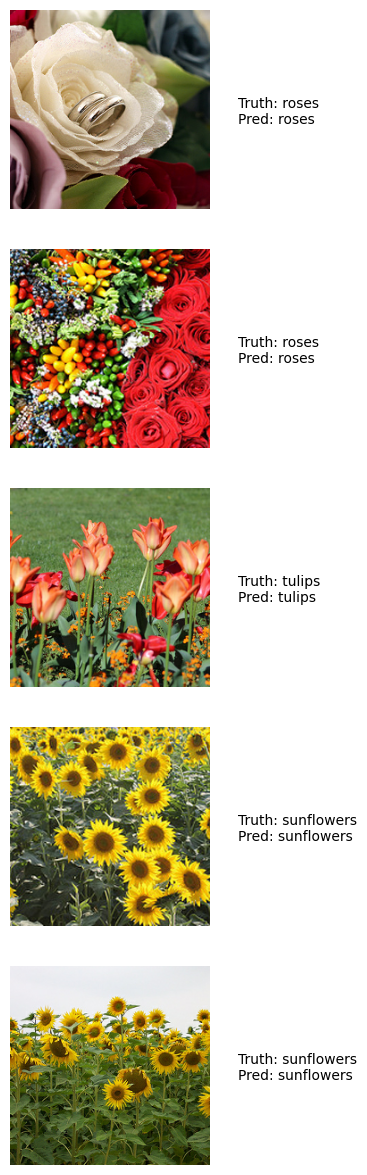

In [ ]:
#@title Plot the images and predictions
fig, axes = plt.subplots(5, 1, figsize=(15, 15))
for i in range(5):
  axes[i].imshow(image[i])
  true_text = tf_flowers_labels[labels[i]]
  pred_text = tf_flowers_labels[pred[i]]
  axes[i].axis('off')
  axes[i].text(256, 128, 'Truth: ' + true_text + '\n' + 'Pred: ' + pred_text)